**<font  size=6> 多因子測試 </font>**

In [1]:
import pymssql
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import pyodbc
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
import os
from numpy import abs
from numpy import log
from numpy import sign
from scipy.stats import rankdata

**<font  size=6> 獲取數據與數據整理 </font>**

In [2]:
class get_df:
    DB_infos = {"X01" : ("192.168.1.16", "X01", "cm", "cm1234")}
    querys = {"日收盤排行" : """SELECT  [日期]
                                      ,[股票代號]
                                      ,[開盤價]
                                      ,[最高價]
                                      ,[最低價]
                                      ,[收盤價]
                                      ,[漲幅(%)]
                                      ,[成交量]
                                      ,[成交金額(千)]
                                  FROM [X01].[dbo].[日收盤表排行] WHERE 日期 >= '20200101' AND 日期 <='20211231'"""}
    db = "Data"
    df_dict =  dict()
    w_code_dict = dict()
    point_dict = dict()
    result_dict = dict()
    def db_connect(self, DB_info):
        DB_Host, DB_Name, DB_User, DB_Password = self.DB_infos[DB_info]
        print("Connecting to database using pyodbc...")
        self.db = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)
        print("Succesfully Connected to database using pyodbc!")
      
    def load_data(self, query):
        df =  pd.read_sql(self.querys[query], self.db)
        self.df_dict.update({str(query) : df})

In [3]:
sql_base = get_df()

In [19]:
sql_base.db_connect("X01")
sql_base.load_data("日收盤排行")
sql_base.df_dict["日收盤排行"] = sql_base.df_dict["日收盤排行"][sql_base.df_dict["日收盤排行"]['日期']<= '20211231']
file = os.listdir("D:\\股票歷史資料_各年度合併")
files = os.listdir("D:\\股票歷史資料_各年度合併上櫃")
file.extend(files)
file = list(pd.Series(file).str[0:-4])
sql_base.df_dict["日收盤排行"] = sql_base.df_dict["日收盤排行"][sql_base.df_dict["日收盤排行"]['股票代號'].isin(file)]
sql_base.df_dict["日收盤排行"].to_csv("D:\\日收盤排行\\日收盤排行.csv")

Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


In [4]:
#生成pivot_table
sql_base.df_dict["日收盤排行"] = pd.read_csv("D:\\日收盤排行\\日收盤排行.csv")
sql_base.df_dict["日收盤排行"] = sql_base.df_dict["日收盤排行"].drop(columns = 'Unnamed: 0')
sql_base.df_dict['開盤價'] = sql_base.df_dict["日收盤排行"].pivot_table(index =['日期'], columns = '股票代號', values = '開盤價')
sql_base.df_dict['最高價'] = sql_base.df_dict["日收盤排行"].pivot_table(index =['日期'], columns = '股票代號', values = '最高價')
sql_base.df_dict['最低價'] = sql_base.df_dict["日收盤排行"].pivot_table(index =['日期'], columns = '股票代號', values = '最低價')
sql_base.df_dict['收盤價'] = sql_base.df_dict["日收盤排行"].pivot_table(index =['日期'], columns = '股票代號', values = '收盤價')
sql_base.df_dict['漲幅(%)'] = sql_base.df_dict["日收盤排行"].pivot_table(index =['日期'], columns = '股票代號', values = '漲幅(%)')
sql_base.df_dict['成交量'] = sql_base.df_dict["日收盤排行"].pivot_table(index =['日期'], columns = '股票代號', values = '成交量')
sql_base.df_dict['成交金額(千)'] = sql_base.df_dict["日收盤排行"].pivot_table(index =['日期'], columns = '股票代號', values = '成交量')

In [5]:
#將pivot_table合併成MultiIndex的Dataframe
df_open = sql_base.df_dict['開盤價'].copy()
ls_open = []
for i in range(2113):
    ls_open.append('open')
tuples  = list(zip(ls_open,list(df_open.columns)))
index = pd.MultiIndex.from_tuples(tuples)
df_open.columns = index

df_high = sql_base.df_dict['最高價'].copy()
ls = []
for i in range(2113):
    ls.append('high')
tuples  = list(zip(ls,list(df_high.columns)))
index = pd.MultiIndex.from_tuples(tuples)
df_high.columns = index

df_low = sql_base.df_dict['最低價'].copy()
ls = []
for i in range(2113):
    ls.append('low')
tuples  = list(zip(ls,list(df_low.columns)))
index = pd.MultiIndex.from_tuples(tuples)
df_low.columns = index

df_close = sql_base.df_dict['收盤價'].copy()
ls = []
for i in range(2113):
    ls.append('close')
tuples  = list(zip(ls,list(df_close.columns)))
index = pd.MultiIndex.from_tuples(tuples)
df_close.columns = index

df_vol = sql_base.df_dict['成交量'].copy()
ls = []
for i in range(2113):
    ls.append('vol')
tuples  = list(zip(ls,list(df_vol.columns)))
index = pd.MultiIndex.from_tuples(tuples)
df_vol.columns = index

df_pct_chg = sql_base.df_dict['漲幅(%)'].copy()
ls = []
for i in range(2113):
    ls.append('pct_chg')
tuples  = list(zip(ls,list(df_pct_chg.columns)))
index = pd.MultiIndex.from_tuples(tuples)
df_pct_chg.columns = index

df_amount = sql_base.df_dict['成交金額(千)'].copy()
ls = []
for i in range(2113):
    ls.append('amount')
tuples  = list(zip(ls,list(df_amount.columns)))
index = pd.MultiIndex.from_tuples(tuples)
df_amount.columns = index

df = df_open.merge(df_high,left_index=True,right_index=True)
df = df.merge(df_low,left_index=True,right_index=True)
df = df.merge(df_close,left_index=True,right_index=True)
df = df.merge(df_vol,left_index=True,right_index=True)
df = df.merge(df_pct_chg,left_index=True,right_index=True)
df = df.merge(df_amount,left_index=True,right_index=True)
df = df.fillna(value=0)

**<font  size=6> 定義因子與計算因子相關性 </font>**

In [6]:
# region Auxiliary functions
def ts_sum(df, window=10):
    """
    Wrapper function to estimate rolling sum.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    
    return df.rolling(window).sum()

def sma(df, window=10):
    """
    Wrapper function to estimate SMA.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).mean()

def stddev(df, window=10):
    """
    Wrapper function to estimate rolling standard deviation.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).std()

def correlation(x, y, window=10):
    """
    Wrapper function to estimate rolling corelations.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).corr(y)

def covariance(x, y, window=10):
    """
    Wrapper function to estimate rolling covariance.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).cov(y)

def rolling_rank(na):
    """
    Auxiliary function to be used in pd.rolling_apply
    :param na: numpy array.
    :return: The rank of the last value in the array.
    """
    return rankdata(na)[-1]

def ts_rank(df, window=10):
    """
    Wrapper function to estimate rolling rank.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series rank over the past window days.
    """
    return df.rolling(window).apply(rolling_rank)

def rolling_prod(na):
    """
    Auxiliary function to be used in pd.rolling_apply
    :param na: numpy array.
    :return: The product of the values in the array.
    """
    return np.prod(na)

def product(df, window=10):
    """
    Wrapper function to estimate rolling product.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series product over the past 'window' days.
    """
    return df.rolling(window).apply(rolling_prod)

def ts_min(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).min()

def ts_max(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series max over the past 'window' days.
    """
    return df.rolling(window).max()

def delta(df, period=1):
    """
    Wrapper function to estimate difference.
    :param df: a pandas DataFrame.
    :param period: the difference grade.
    :return: a pandas DataFrame with today’s value minus the value 'period' days ago.
    """
    return df.diff(int(period))

def delay(df, period=1):
    """
    Wrapper function to estimate lag.
    :param df: a pandas DataFrame.
    :param period: the lag grade.
    :return: a pandas DataFrame with lagged time series
    """
    return df.shift(period)

def rank(df):
    """
    Cross sectional rank
    :param df: a pandas DataFrame.
    :return: a pandas DataFrame with rank along columns.
    """
    #return df.rank(axis=1, pct=True)
    return df.rank(pct=True)

def scale(df, k=1):
    """
    Scaling time serie.
    :param df: a pandas DataFrame.
    :param k: scaling factor.
    :return: a pandas DataFrame rescaled df such that sum(abs(df)) = k
    """
    return df.mul(k).div(np.abs(df).sum())

def ts_argmax(df, window=10):
    """
    Wrapper function to estimate which day ts_max(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return df.rolling(window).apply(np.argmax) + 1 

def ts_argmin(df, window=10):
    """
    Wrapper function to estimate which day ts_min(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return df.rolling(window).apply(np.argmin) + 1

def decay_linear(df, period=10):
    """
    Linear weighted moving average implementation.
    :param df: a pandas DataFrame.
    :param period: the LWMA period
    :return: a pandas DataFrame with the LWMA.
    """
    # Clean data
    if df.isnull().values.any():
        df.fillna(method='ffill', inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(value=0, inplace=True)
    na_lwma = np.zeros_like(df)
    na_lwma[:period, :] = df.iloc[:period, :] 
    na_series = df.values # changed here

    divisor = period * (period + 1) / 2
    y = (np.arange(period) + 1) * 1.0 / divisor
    # Estimate the actual lwma with the actual close.
    # The backtest engine should assure to be snooping bias free.
    for row in range(period - 1, df.shape[0]):
        x = na_series[row - period + 1: row + 1, :]
        na_lwma[row, :] = (np.dot(x.T, y))
    return pd.DataFrame(na_lwma, index=df.index)
# endregion

def get_alpha(df,decay):
        stock=Alphas(df)
        df['alpha001IC']=stock.alpha001().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha002IC']=stock.alpha002().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha003IC']=stock.alpha003().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha004IC']=stock.alpha004().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha005IC']=stock.alpha005().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha006IC']=stock.alpha006().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha007IC']=stock.alpha007().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha008IC']=stock.alpha008().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha009IC']=stock.alpha009().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha010IC']=stock.alpha010().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha011IC']=stock.alpha011().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha012IC']=stock.alpha012().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha013IC']=stock.alpha013().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha014IC']=stock.alpha014().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha015IC']=stock.alpha015().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha016IC']=stock.alpha016().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha017IC']=stock.alpha017().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha018IC']=stock.alpha018().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha019IC']=stock.alpha019().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha020IC']=stock.alpha020().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha021IC']=stock.alpha021().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha022IC']=stock.alpha022().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha023IC']=stock.alpha023().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha024IC']=stock.alpha024().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha025IC']=stock.alpha025().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha026IC']=stock.alpha026().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha027IC']=stock.alpha027().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha028IC']=stock.alpha028().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha029IC']=stock.alpha029().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha030IC']=stock.alpha030().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha031IC']=stock.alpha031().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha032IC']=stock.alpha032().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha033IC']=stock.alpha033().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha034IC']=stock.alpha034().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha035IC']=stock.alpha035().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha036IC']=stock.alpha036().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha037IC']=stock.alpha037().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha038IC']=stock.alpha038().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha039IC']=stock.alpha039().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha040IC']=stock.alpha040().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha041IC']=stock.alpha041().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha042IC']=stock.alpha042().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha043IC']=stock.alpha043().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha044IC']=stock.alpha044().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha045IC']=stock.alpha045().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha046IC']=stock.alpha046().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha047IC']=stock.alpha047().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha049IC']=stock.alpha049().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha050IC']=stock.alpha050().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha051IC']=stock.alpha051().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha052IC']=stock.alpha052().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha053IC']=stock.alpha053().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha054IC']=stock.alpha054().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha055IC']=stock.alpha055().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha057IC']=stock.alpha057().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha060IC']=stock.alpha060().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha061IC']=stock.alpha061().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha062IC']=stock.alpha062().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha064IC']=stock.alpha064().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha065IC']=stock.alpha065().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha066IC']=stock.alpha066().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha068IC']=stock.alpha068().corrwith(df['pct_chg'].shift(-decay),axis=1)
        #df['alpha071IC']=stock.alpha071().corrwith(df['pct_chg'].shift(-1),axis=1)
        df['alpha072IC']=stock.alpha072().corrwith(df['pct_chg'].shift(-1),axis=1)
        #df['alpha073IC']=stock.alpha073().corrwith(df['pct_chg'].shift(-1),axis=1)
        df['alpha074IC']=stock.alpha074().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha075IC']=stock.alpha075().corrwith(df['pct_chg'].shift(-decay),axis=1)
        #df['alpha077IC']=stock.alpha077().corrwith(df['pct_chg'].shift(-1),axis=1)
        df['alpha078IC']=stock.alpha078().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha081IC']=stock.alpha081().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha083IC']=stock.alpha083().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha084IC']=stock.alpha084().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha085IC']=stock.alpha085().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha086IC']=stock.alpha086().corrwith(df['pct_chg'].shift(-decay),axis=1)
        #df['alpha088IC']=stock.alpha088().corrwith(df['pct_chg'].shift(-1),axis=1)
        #df['alpha092IC']=stock.alpha092().corrwith(df['pct_chg'].shift(-1),axis=1)
        df['alpha094IC']=stock.alpha094().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha095IC']=stock.alpha095().corrwith(df['pct_chg'].shift(-decay),axis=1)
        #df['alpha096IC']=stock.alpha096().corrwith(df['pct_chg'].shift(-1),axis=1)
        df['alpha098IC']=stock.alpha098().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha099IC']=stock.alpha099().corrwith(df['pct_chg'].shift(-decay),axis=1)
        df['alpha101IC']=stock.alpha101().corrwith(df['pct_chg'].shift(-decay),axis=1)
        return df

class Alphas(object):
    def __init__(self, df_data):

        df_data = df_data.fillna(value=0)
        self.open = df_data['open']
        self.high = df_data['high']
        self.low = df_data['low']
        self.close = df_data['close']
        self.volume = df_data['vol']*100
        self.returns = df_data['pct_chg']
        self.vwap = (df_data['amount']*1000)/(df_data['vol']*100+1)
        
    # Alpha#1	 (rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) -0.5)
    def alpha001(self):
        inner = self.close
        inner[self.returns < 0] = stddev(self.returns, 20)
        return rank(ts_argmax(inner ** 2, 5))
    
    # Alpha#2	 (-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))
    def alpha002(self):
        df = -1 * correlation(rank(delta(log(self.volume), 2)), rank((self.close - self.open) / self.open), 6)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
    
    # Alpha#3	 (-1 * correlation(rank(open), rank(volume), 10))
    def alpha003(self):
        df = -1 * correlation(rank(self.open), rank(self.volume), 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
    
    # Alpha#4	 (-1 * Ts_Rank(rank(low), 9))
    def alpha004(self):
        return -1 * ts_rank(rank(self.low), 9)
    
    # Alpha#5	 (rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))
    def alpha005(self):
        #return  (rank((self.open - (sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
        return (rank((self.open - (np.sum(self.vwap)+10 / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
    
    # Alpha#6	 (-1 * correlation(open, volume, 10))
    def alpha006(self):
        df = -1 * correlation(self.open, self.volume, 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
    
    # Alpha#7	 ((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1* 1))
    def alpha007(self):
        adv20 = sma(self.volume, 20)
        alpha = -1 * ts_rank(abs(delta(self.close, 7)), 60) * sign(delta(self.close, 7))
        alpha[adv20 >= self.volume] = -1
        return alpha
    
    # Alpha#8	 (-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)),10))))
    def alpha008(self):
        return -1 * (rank(((ts_sum(self.open, 5) * ts_sum(self.returns, 5)) -
                           delay((ts_sum(self.open, 5) * ts_sum(self.returns, 5)), 10))))
    
    # Alpha#9	 ((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ?delta(close, 1) : (-1 * delta(close, 1))))
    def alpha009(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 5) > 0
        cond_2 = ts_max(delta_close, 5) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha
    
    # Alpha#10	 rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0)? delta(close, 1) : (-1 * delta(close, 1)))))
    def alpha010(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 4) > 0
        cond_2 = ts_max(delta_close, 4) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha
    
    # Alpha#11	 ((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) *rank(delta(volume, 3)))
    def alpha011(self):
        return ((rank(ts_max((self.vwap - self.close), 3)) + rank(ts_min((self.vwap - self.close), 3))) *rank(delta(self.volume, 3)))
    
    # Alpha#12	 (sign(delta(volume, 1)) * (-1 * delta(close, 1)))
    def alpha012(self):
        return sign(delta(self.volume, 1)) * (-1 * delta(self.close, 1))

    # Alpha#13	 (-1 * rank(covariance(rank(close), rank(volume), 5)))
    def alpha013(self):
        return -1 * rank(covariance(rank(self.close), rank(self.volume), 5))
    
    # Alpha#14	 ((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))
    def alpha014(self):
        df = correlation(self.open, self.volume, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * rank(delta(self.returns, 3)) * df
    
    # Alpha#15	 (-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3))
    def alpha015(self):
        df = correlation(rank(self.high), rank(self.volume), 3)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * ts_sum(rank(df), 3)
    
    # Alpha#16	 (-1 * rank(covariance(rank(high), rank(volume), 5)))
    def alpha016(self):
        return -1 * rank(covariance(rank(self.high), rank(self.volume), 5))
    
    # Alpha#17	 (((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) *rank(ts_rank((volume / adv20), 5)))
    def alpha017(self):
        adv20 = sma(self.volume, 20)
        return -1 * (rank(ts_rank(self.close, 10)) *
                     rank(delta(delta(self.close, 1), 1)) *
                     rank(ts_rank((self.volume / adv20), 5)))
        
    # Alpha#18	 (-1 * rank(((stddev(abs((close - open)), 5) + (close - open)) + correlation(close, open,10))))
    def alpha018(self):
        df = correlation(self.close, self.open, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * (rank((stddev(abs((self.close - self.open)), 5) + (self.close - self.open)) +
                          df))
    
    # Alpha#19	 ((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + sum(returns,250)))))
    def alpha019(self):
        return ((-1 * sign((self.close - delay(self.close, 7)) + delta(self.close, 7))) *
                (1 + rank(1 + ts_sum(self.returns, 250))))
    
    # Alpha#20	 (((-1 * rank((open - delay(high, 1)))) * rank((open - delay(close, 1)))) * rank((open -delay(low, 1))))
    def alpha020(self):
        return -1 * (rank(self.open - delay(self.high, 1)) *
                     rank(self.open - delay(self.close, 1)) *
                     rank(self.open - delay(self.low, 1)))

    # Alpha#21	 ((((sum(close, 8) / 8) + stddev(close, 8)) < (sum(close, 2) / 2)) ? (-1 * 1) : (((sum(close,2) / 2) < ((sum(close, 8) / 8) - stddev(close, 8))) ? 1 : (((1 < (volume / adv20)) || ((volume /adv20) == 1)) ? 1 : (-1 * 1))))
    def alpha021(self):
        cond_1 = sma(self.close, 8) + stddev(self.close, 8) < sma(self.close, 2)
        cond_2 = sma(self.volume, 20) / self.volume < 1
        alpha = pd.DataFrame(np.ones_like(self.close), index=self.close.index
                             )
#        alpha = pd.DataFrame(np.ones_like(self.close), index=self.close.index,
#                             columns=self.close.columns)
        alpha[cond_1 | cond_2] = -1
        return alpha
    
    # Alpha#22	 (-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20))))
    def alpha022(self):
        df = correlation(self.high, self.volume, 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * delta(df, 5) * rank(stddev(self.close, 20))

    # Alpha#23	 (((sum(high, 20) / 20) < high) ? (-1 * delta(high, 2)) : 0)
    def alpha023(self):
        cond = sma(self.high, 20) < self.high
        alpha = pd.DataFrame(np.zeros_like(self.close),index=self.close.index)
        alpha[cond] = -1 * delta(self.high, 2).fillna(value=0)
        return alpha
    
    # Alpha#24	 ((((delta((sum(close, 100) / 100), 100) / delay(close, 100)) < 0.05) ||((delta((sum(close, 100) / 100), 100) / delay(close, 100)) == 0.05)) ? (-1 * (close - ts_min(close,100))) : (-1 * delta(close, 3)))
    def alpha024(self):
        cond = delta(sma(self.close, 100), 100) / delay(self.close, 100) <= 0.05
        alpha = -1 * delta(self.close, 3)
        alpha[cond] = -1 * (self.close - ts_min(self.close, 100))
        return alpha
    
    # Alpha#25	 rank(((((-1 * returns) * adv20) * vwap) * (high - close)))
    def alpha025(self):
        adv20 = sma(self.volume, 20)
        return rank(((((-1 * self.returns) * adv20) * self.vwap) * (self.high - self.close)))
    
    # Alpha#26	 (-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))
    def alpha026(self):
        df = correlation(ts_rank(self.volume, 5), ts_rank(self.high, 5), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * ts_max(df, 3)
    
    # Alpha#27	 ((0.5 < rank((sum(correlation(rank(volume), rank(vwap), 6), 2) / 2.0))) ? (-1 * 1) : 1)
    #可能存在问题，我自己的数据测试了很多次值全为1，可能需要调整6,2这些参数？
    def alpha027(self):
        alpha = rank((sma(correlation(rank(self.volume), rank(self.vwap), 6), 2) / 2.0))
        alpha[alpha > 0.5] = -1
        alpha[alpha <= 0.5]=1
        return alpha  
    
    # Alpha#28	 scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))
    def alpha028(self):
        adv20 = sma(self.volume, 20)
        df = correlation(adv20, self.low, 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return scale(((df + ((self.high + self.low) / 2)) - self.close))

    # Alpha#29	 (min(product(rank(rank(scale(log(sum(ts_min(rank(rank((-1 * rank(delta((close - 1),5))))), 2), 1))))), 1), 5) + ts_rank(delay((-1 * returns), 6), 5))
    def alpha029(self):
        return (ts_min(rank(rank(scale(log(ts_sum(rank(rank(-1 * rank(delta((self.close - 1), 5)))), 2))))), 5) +
                ts_rank(delay((-1 * self.returns), 6), 5))

    # Alpha#30	 (((1.0 - rank(((sign((close - delay(close, 1))) + sign((delay(close, 1) - delay(close, 2)))) +sign((delay(close, 2) - delay(close, 3)))))) * sum(volume, 5)) / sum(volume, 20))
    def alpha030(self):
        delta_close = delta(self.close, 1)
        inner = sign(delta_close) + sign(delay(delta_close, 1)) + sign(delay(delta_close, 2))
        return ((1.0 - rank(inner)) * ts_sum(self.volume, 5)) / ts_sum(self.volume, 20)

    # Alpha#31	 ((rank(rank(rank(decay_linear((-1 * rank(rank(delta(close, 10)))), 10)))) + rank((-1 *delta(close, 3)))) + sign(scale(correlation(adv20, low, 12))))
    def alpha031(self):
        adv20 = sma(self.volume, 20)
        df = correlation(adv20, self.low, 12).replace([-np.inf, np.inf], 0).fillna(value=0)         
        p1=rank(rank(rank(decay_linear((-1 * rank(rank(delta(self.close, 10)))), 10))))
        p2=rank((-1 * delta(self.close, 3)))
        p3=sign(scale(df))
        
        return p1+p2+p3

    # Alpha#32	 (scale(((sum(close, 7) / 7) - close)) + (20 * scale(correlation(vwap, delay(close, 5),230))))
    def alpha032(self):
        return scale(((sma(self.close, 7) / 7) - self.close)) + (20 * scale(correlation(self.vwap, delay(self.close, 5),230)))
    
    # Alpha#33	 rank((-1 * ((1 - (open / close))^1)))
    def alpha033(self):
        return rank(-1 + (self.open / self.close))
    
    # Alpha#34	 rank(((1 - rank((stddev(returns, 2) / stddev(returns, 5)))) + (1 - rank(delta(close, 1)))))
    def alpha034(self):
        inner = stddev(self.returns, 2) / stddev(self.returns, 5)
        inner = inner.replace([-np.inf, np.inf], 1).fillna(value=1)
        return rank(2 - rank(inner) - rank(delta(self.close, 1)))

    # Alpha#35	 ((Ts_Rank(volume, 32) * (1 - Ts_Rank(((close + high) - low), 16))) * (1 -Ts_Rank(returns, 32)))
    def alpha035(self):
        return ((ts_rank(self.volume, 32) *
                 (1 - ts_rank(self.close + self.high - self.low, 16))) *
                (1 - ts_rank(self.returns, 32)))
            
    # Alpha#36	 (((((2.21 * rank(correlation((close - open), delay(volume, 1), 15))) + (0.7 * rank((open- close)))) + (0.73 * rank(Ts_Rank(delay((-1 * returns), 6), 5)))) + rank(abs(correlation(vwap,adv20, 6)))) + (0.6 * rank((((sum(close, 200) / 200) - open) * (close - open)))))
    def alpha036(self):
        adv20 = sma(self.volume, 20)
        return (((((2.21 * rank(correlation((self.close - self.open), delay(self.volume, 1), 15))) + (0.7 * rank((self.open- self.close)))) + (0.73 * rank(ts_rank(delay((-1 * self.returns), 6), 5)))) + rank(abs(correlation(self.vwap,adv20, 6)))) + (0.6 * rank((((sma(self.close, 200) / 200) - self.open) * (self.close - self.open)))))
    
    # Alpha#37	 (rank(correlation(delay((open - close), 1), close, 200)) + rank((open - close)))
    def alpha037(self):
        return rank(correlation(delay(self.open - self.close, 1), self.close, 200)) + rank(self.open - self.close)
    
    # Alpha#38	 ((-1 * rank(Ts_Rank(close, 10))) * rank((close / open)))
    def alpha038(self):
        inner = self.close / self.open
        inner = inner.replace([-np.inf, np.inf], 1).fillna(value=1)
        return -1 * rank(ts_rank(self.open, 10)) * rank(inner)
    
    # Alpha#39	 ((-1 * rank((delta(close, 7) * (1 - rank(decay_linear((volume / adv20), 9)))))) * (1 +rank(sum(returns, 250))))
    def alpha039(self):
        adv20 = sma(self.volume, 20)
        return ((-1 * rank(delta(self.close, 7) * (1 - rank(decay_linear((self.volume / adv20), 9))))) *
                (1 + rank(sma(self.returns, 250))))
    
    # Alpha#40	 ((-1 * rank(stddev(high, 10))) * correlation(high, volume, 10))
    def alpha040(self):
        return -1 * rank(stddev(self.high, 10)) * correlation(self.high, self.volume, 10)

    # Alpha#41	 (((high * low)^0.5) - vwap)
    def alpha041(self):
        return pow((self.high * self.low),0.5) - self.vwap
    
    # Alpha#42	 (rank((vwap - close)) / rank((vwap + close)))
    def alpha042(self):
        return rank((self.vwap - self.close)) / rank((self.vwap + self.close))
        
    # Alpha#43	 (ts_rank((volume / adv20), 20) * ts_rank((-1 * delta(close, 7)), 8))
    def alpha043(self):
        adv20 = sma(self.volume, 20)
        return ts_rank(self.volume / adv20, 20) * ts_rank((-1 * delta(self.close, 7)), 8)

    # Alpha#44	 (-1 * correlation(high, rank(volume), 5))
    def alpha044(self):
        df = correlation(self.high, rank(self.volume), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * df

    # Alpha#45	 (-1 * ((rank((sum(delay(close, 5), 20) / 20)) * correlation(close, volume, 2)) *rank(correlation(sum(close, 5), sum(close, 20), 2))))
    def alpha045(self):
        df = correlation(self.close, self.volume, 2)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * (rank(sma(delay(self.close, 5), 20)) * df *
                     rank(correlation(ts_sum(self.close, 5), ts_sum(self.close, 20), 2)))
    
    # Alpha#46	 ((0.25 < (((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10))) ?(-1 * 1) : (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < 0) ? 1 :((-1 * 1) * (close - delay(close, 1)))))
    def alpha046(self):
        inner = ((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10)
        alpha = (-1 * delta(self.close))
        alpha[inner < 0] = 1
        alpha[inner > 0.25] = -1
        return alpha

    # Alpha#47	 ((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) / (sum(high, 5) /5))) - rank((vwap - delay(vwap, 5))))
    def alpha047(self):
        adv20 = sma(self.volume, 20)
        return ((((rank((1 / self.close)) * self.volume) / adv20) * ((self.high * rank((self.high - self.close))) / (sma(self.high, 5) /5))) - rank((self.vwap - delay(self.vwap, 5))))
    
    # Alpha#48	 (indneutralize(((correlation(delta(close, 1), delta(delay(close, 1), 1), 250) *delta(close, 1)) / close), IndClass.subindustry) / sum(((delta(close, 1) / delay(close, 1))^2), 250))
     
    
    # Alpha#49	 (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.1)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))
    def alpha049(self):
        inner = (((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10))
        alpha = (-1 * delta(self.close))
        alpha[inner < -0.1] = 1
        return alpha
    
    # Alpha#50	 (-1 * ts_max(rank(correlation(rank(volume), rank(vwap), 5)), 5))
    def alpha050(self):
        return (-1 * ts_max(rank(correlation(rank(self.volume), rank(self.vwap), 5)), 5))
    
    # Alpha#51	 (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.05)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))
    def alpha051(self):
        inner = (((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10))
        alpha = (-1 * delta(self.close))
        alpha[inner < -0.05] = 1
        return alpha
    
    # Alpha#52	 ((((-1 * ts_min(low, 5)) + delay(ts_min(low, 5), 5)) * rank(((sum(returns, 240) -sum(returns, 20)) / 220))) * ts_rank(volume, 5))
    def alpha052(self):
        return (((-1 * delta(ts_min(self.low, 5), 5)) *
                 rank(((ts_sum(self.returns, 240) - ts_sum(self.returns, 20)) / 220))) * ts_rank(self.volume, 5))
        
    # Alpha#53	 (-1 * delta((((close - low) - (high - close)) / (close - low)), 9))
    def alpha053(self):
        inner = (self.close - self.low).replace(0, 0.0001)
        return -1 * delta((((self.close - self.low) - (self.high - self.close)) / inner), 9)

    # Alpha#54	 ((-1 * ((low - close) * (open^5))) / ((low - high) * (close^5)))
    def alpha054(self):
        inner = (self.low - self.high).replace(0, -0.0001)
        return -1 * (self.low - self.close) * (self.open ** 5) / (inner * (self.close ** 5))

    # Alpha#55	 (-1 * correlation(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low,12)))), rank(volume), 6))
    def alpha055(self):
        divisor = (ts_max(self.high, 12) - ts_min(self.low, 12)).replace(0, 0.0001)
        inner = (self.close - ts_min(self.low, 12)) / (divisor)
        df = correlation(rank(inner), rank(self.volume), 6)
        return -1 * df.replace([-np.inf, np.inf], 0).fillna(value=0)

    # Alpha#56	 (0 - (1 * (rank((sum(returns, 10) / sum(sum(returns, 2), 3))) * rank((returns * cap)))))
    #本Alpha使用了cap|市值，暂未取到该值
#    def alpha056(self):
#        return (0 - (1 * (rank((sma(self.returns, 10) / sma(sma(self.returns, 2), 3))) * rank((self.returns * self.cap)))))
    
    # Alpha#57	 (0 - (1 * ((close - vwap) / decay_linear(rank(ts_argmax(close, 30)), 2))))
    def alpha057(self):
        return (0 - (1 * ((self.close - self.vwap) / decay_linear(rank(ts_argmax(self.close, 30)), 2))))
    
    # Alpha#58	 (-1 * Ts_Rank(decay_linear(correlation(IndNeutralize(vwap, IndClass.sector), volume,3.92795), 7.89291), 5.50322))
     
    # Alpha#59	 (-1 * Ts_Rank(decay_linear(correlation(IndNeutralize(((vwap * 0.728317) + (vwap *(1 - 0.728317))), IndClass.industry), volume, 4.25197), 16.2289), 8.19648))
     
    
    # Alpha#60	 (0 - (1 * ((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume)))) -scale(rank(ts_argmax(close, 10))))))
    def alpha060(self):
        divisor = (self.high - self.low).replace(0, 0.0001)
        inner = ((self.close - self.low) - (self.high - self.close)) * self.volume / divisor
        return - ((2 * scale(rank(inner))) - scale(rank(ts_argmax(self.close, 10))))
    
	# Alpha#61	 (rank((vwap - ts_min(vwap, 16.1219))) < rank(correlation(vwap, adv180, 17.9282)))
    def alpha061(self):
        adv180 = sma(self.volume, 180)
        return (rank((self.vwap - ts_min(self.vwap, 16))) < rank(correlation(self.vwap, adv180, 18)))
    
	# Alpha#62	 ((rank(correlation(vwap, sum(adv20, 22.4101), 9.91009)) < rank(((rank(open) +rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)
    def alpha062(self):
        adv20 = sma(self.volume, 20)
        return ((rank(correlation(self.vwap, sma(adv20, 22), 10)) < rank(((rank(self.open) +rank(self.open)) < (rank(((self.high + self.low) / 2)) + rank(self.high))))) * -1)
    
    # Alpha#63	 ((rank(decay_linear(delta(IndNeutralize(close, IndClass.industry), 2.25164), 8.22237))- rank(decay_linear(correlation(((vwap * 0.318108) + (open * (1 - 0.318108))), sum(adv180,37.2467), 13.557), 12.2883))) * -1)
     
    
    # Alpha#64	 ((rank(correlation(sum(((open * 0.178404) + (low * (1 - 0.178404))), 12.7054),sum(adv120, 12.7054), 16.6208)) < rank(delta(((((high + low) / 2) * 0.178404) + (vwap * (1 -0.178404))), 3.69741))) * -1)
    def alpha064(self):
        adv120 = sma(self.volume, 120)
        return ((rank(correlation(sma(((self.open * 0.178404) + (self.low * (1 - 0.178404))), 13),sma(adv120, 13), 17)) < rank(delta(((((self.high + self.low) / 2) * 0.178404) + (self.vwap * (1 -0.178404))), 3.69741))) * -1)
    
    # Alpha#65	 ((rank(correlation(((open * 0.00817205) + (vwap * (1 - 0.00817205))), sum(adv60,8.6911), 6.40374)) < rank((open - ts_min(open, 13.635)))) * -1)
    def alpha065(self):
        adv60 = sma(self.volume, 60)
        return ((rank(correlation(((self.open * 0.00817205) + (self.vwap * (1 - 0.00817205))), sma(adv60,9), 6)) < rank((self.open - ts_min(self.open, 14)))) * -1)
      
    # Alpha#66	 ((rank(decay_linear(delta(vwap, 3.51013), 7.23052)) + Ts_Rank(decay_linear(((((low* 0.96633) + (low * (1 - 0.96633))) - vwap) / (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)
    def alpha066(self):
        return ((rank(decay_linear(delta(self.vwap, 4), 7)) + ts_rank(decay_linear(((((self.low* 0.96633) + (self.low * (1 - 0.96633))) - self.vwap) / (self.open - ((self.high + self.low) / 2))), 11), 7)) * -1)
    
    # Alpha#67	 ((rank((high - ts_min(high, 2.14593)))^rank(correlation(IndNeutralize(vwap,IndClass.sector), IndNeutralize(adv20, IndClass.subindustry), 6.02936))) * -1)
     
    
    # Alpha#68	 ((Ts_Rank(correlation(rank(high), rank(adv15), 8.91644), 13.9333) <rank(delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)
    def alpha068(self):
        adv15 = sma(self.volume, 15)
        return ((ts_rank(correlation(rank(self.high), rank(adv15), 9), 14) <rank(delta(((self.close * 0.518371) + (self.low * (1 - 0.518371))), 1.06157))) * -1)
    
    # Alpha#69	 ((rank(ts_max(delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344))^Ts_Rank(correlation(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615)) * -1)
         
    # Alpha#70	 ((rank(delta(vwap, 1.29456))^Ts_Rank(correlation(IndNeutralize(close,IndClass.industry), adv50, 17.8256), 17.9171)) * -1)
     
    
    # Alpha#71	 max(Ts_Rank(decay_linear(correlation(Ts_Rank(close, 3.43976), Ts_Rank(adv180,12.0647), 18.0175), 4.20501), 15.6948), Ts_Rank(decay_linear((rank(((low + open) - (vwap +vwap)))^2), 16.4662), 4.4388))
    def alpha071(self):
        adv180 = sma(self.volume, 180)
        p1=ts_rank(decay_linear(correlation(ts_rank(self.close, 3), ts_rank(adv180,12), 18), 4), 16)
        p2=ts_rank(decay_linear((rank(((self.low + self.open) - (self.vwap +self.vwap))).pow(2)), 16), 4)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'max']=df['p1']
        df.at[df['p2']>=df['p1'],'max']=df['p2']
        return df['max']
        #return max(ts_rank(decay_linear(correlation(ts_rank(self.close, 3), ts_rank(adv180,12), 18).to_frame(), 4).CLOSE, 16), ts_rank(decay_linear((rank(((self.low + self.open) - (self.vwap +self.vwap))).pow(2)).to_frame(), 16).CLOSE, 4))
    
    # Alpha#72	 (rank(decay_linear(correlation(((high + low) / 2), adv40, 8.93345), 10.1519)) /rank(decay_linear(correlation(Ts_Rank(vwap, 3.72469), Ts_Rank(volume, 18.5188), 6.86671),2.95011)))
    def alpha072(self):
        adv40 = sma(self.volume, 40)
        return (rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 9), 10)) /rank(decay_linear(correlation(ts_rank(self.vwap, 4), ts_rank(self.volume, 19), 7),3)))
    
    # Alpha#73	 (max(rank(decay_linear(delta(vwap, 4.72775), 2.91864)),Ts_Rank(decay_linear(((delta(((open * 0.147155) + (low * (1 - 0.147155))), 2.03608) / ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)
    def alpha073(self):
        p1=rank(decay_linear(delta(self.vwap, 5), 3))
        p2=ts_rank(decay_linear(((delta(((self.open * 0.147155) + (self.low * (1 - 0.147155))), 2) / ((self.open *0.147155) + (self.low * (1 - 0.147155)))) * -1), 3), 17)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'max']=df['p1']
        df.at[df['p2']>=df['p1'],'max']=df['p2']
        return -1*df['max']
        #return (max(rank(decay_linear(delta(self.vwap, 5).to_frame(), 3).CLOSE),ts_rank(decay_linear(((delta(((self.open * 0.147155) + (self.low * (1 - 0.147155))), 2) / ((self.open *0.147155) + (self.low * (1 - 0.147155)))) * -1).to_frame(), 3).CLOSE, 17)) * -1)
    
    # Alpha#74	 ((rank(correlation(close, sum(adv30, 37.4843), 15.1365)) <rank(correlation(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1)
    def alpha074(self):
        adv30 = sma(self.volume, 30)
        return ((rank(correlation(self.close, sma(adv30, 37), 15)) <rank(correlation(rank(((self.high * 0.0261661) + (self.vwap * (1 - 0.0261661)))), rank(self.volume), 11)))* -1)
    
    # Alpha#75	 (rank(correlation(vwap, volume, 4.24304)) < rank(correlation(rank(low), rank(adv50),12.4413)))
    def alpha075(self):
        adv50 = sma(self.volume, 50)
        return (rank(correlation(self.vwap, self.volume, 4)) < rank(correlation(rank(self.low), rank(adv50),12)))
    
    # Alpha#76	 (max(rank(decay_linear(delta(vwap, 1.24383), 11.8259)),Ts_Rank(decay_linear(Ts_Rank(correlation(IndNeutralize(low, IndClass.sector), adv81,8.14941), 19.569), 17.1543), 19.383)) * -1)
     

    # Alpha#77	 min(rank(decay_linear(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),rank(decay_linear(correlation(((high + low) / 2), adv40, 3.1614), 5.64125)))
    def alpha077(self):
        adv40 = sma(self.volume, 40)
        p1=rank(decay_linear(((((self.high + self.low) / 2) + self.high) - (self.vwap + self.high)), 20))
        p2=rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 3), 6))
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'min']=df['p2']
        df.at[df['p2']>=df['p1'],'min']=df['p1']
        return df['min']
        #return min(rank(decay_linear(((((self.high + self.low) / 2) + self.high) - (self.vwap + self.high)).to_frame(), 20).CLOSE),rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 3).to_frame(), 6).CLOSE))
    
    # Alpha#78	 (rank(correlation(sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),sum(adv40, 19.7428), 6.83313))^rank(correlation(rank(vwap), rank(volume), 5.77492)))
    def alpha078(self):
        adv40 = sma(self.volume, 40)
        return (rank(correlation(ts_sum(((self.low * 0.352233) + (self.vwap * (1 - 0.352233))), 20),ts_sum(adv40,20), 7)).pow(rank(correlation(rank(self.vwap), rank(self.volume), 6))))
    
    # Alpha#79	 (rank(delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < rank(correlation(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
     
    # Alpha#80	 ((rank(Sign(delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545)))^Ts_Rank(correlation(high, adv10, 5.11456), 5.53756)) * -1)
     
   
    # Alpha#81	 ((rank(Log(product(rank((rank(correlation(vwap, sum(adv10, 49.6054),8.47743))^4)), 14.9655))) < rank(correlation(rank(vwap), rank(volume), 5.07914))) * -1)
    def alpha081(self):
        adv10 = sma(self.volume, 10)
        return ((rank(log(product(rank((rank(correlation(self.vwap, ts_sum(adv10, 50),8)).pow(4))), 15))) < rank(correlation(rank(self.vwap), rank(self.volume), 5))) * -1)
    
    # Alpha#82	 (min(rank(decay_linear(delta(open, 1.46063), 14.8717)),Ts_Rank(decay_linear(correlation(IndNeutralize(volume, IndClass.sector), ((open * 0.634196) +(open * (1 - 0.634196))), 17.4842), 6.92131), 13.4283)) * -1)
     
    
    # Alpha#83	 ((rank(delay(((high - low) / (sum(close, 5) / 5)), 2)) * rank(rank(volume))) / (((high -low) / (sum(close, 5) / 5)) / (vwap - close)))
    def alpha083(self):
        return ((rank(delay(((self.high - self.low) / (ts_sum(self.close, 5) / 5)), 2)) * rank(rank(self.volume))) / (((self.high -self.low) / (ts_sum(self.close, 5) / 5)) / (self.vwap - self.close)))
    
    # Alpha#84	 SignedPower(Ts_Rank((vwap - ts_max(vwap, 15.3217)), 20.7127), delta(close,4.96796))
    def alpha084(self):
        return pow(ts_rank((self.vwap - ts_max(self.vwap, 15)), 21), delta(self.close,5))
    
    # Alpha#85	 (rank(correlation(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331))^rank(correlation(Ts_Rank(((high + low) / 2), 3.70596), Ts_Rank(volume, 10.1595),7.11408)))
    def alpha085(self):
        adv30 = sma(self.volume, 30)
        return (rank(correlation(((self.high * 0.876703) + (self.close * (1 - 0.876703))), adv30,10)).pow(rank(correlation(ts_rank(((self.high + self.low) / 2), 4), ts_rank(self.volume, 10),7))))
    
    # Alpha#86	 ((Ts_Rank(correlation(close, sum(adv20, 14.7444), 6.00049), 20.4195) < rank(((open+ close) - (vwap + open)))) * -1)

    def alpha086(self):
        adv20 = sma(self.volume, 20)
        return ((ts_rank(correlation(self.close, sma(adv20, 15), 6), 20) < rank(((self.open+ self.close) - (self.vwap +self.open)))) * -1)
    
    # Alpha#87	 (max(rank(decay_linear(delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), Ts_Rank(decay_linear(abs(correlation(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)
     
    
    # Alpha#88	 min(rank(decay_linear(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)), Ts_Rank(decay_linear(correlation(Ts_Rank(close, 8.44728), Ts_Rank(adv60,20.6966), 8.01266), 6.65053), 2.61957))
    def alpha088(self):
        adv60 = sma(self.volume, 60)
        p1=rank(decay_linear(((rank(self.open) + rank(self.low)) - (rank(self.high) + rank(self.close))),8))
        p2=ts_rank(decay_linear(correlation(ts_rank(self.close, 8), ts_rank(adv60,21), 8), 7), 3)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'min']=df['p2']
        df.at[df['p2']>=df['p1'],'min']=df['p1']
        return df['min']
        #return min(rank(decay_linear(((rank(self.open) + rank(self.low)) - (rank(self.high) + rank(self.close))).to_frame(),8).CLOSE), ts_rank(decay_linear(correlation(ts_rank(self.close, 8), ts_rank(adv60,20.6966), 8).to_frame(), 7).CLOSE, 3))
    
    # Alpha#89	 (Ts_Rank(decay_linear(correlation(((low * 0.967285) + (low * (1 - 0.967285))), adv10,6.94279), 5.51607), 3.79744) - Ts_Rank(decay_linear(delta(IndNeutralize(vwap,IndClass.industry), 3.48158), 10.1466), 15.3012))
     
    # Alpha#90	 ((rank((close - ts_max(close, 4.66719)))^Ts_Rank(correlation(IndNeutralize(adv40,IndClass.subindustry), low, 5.38375), 3.21856)) * -1)
     
    # Alpha#91	 ((Ts_Rank(decay_linear(decay_linear(correlation(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -rank(decay_linear(correlation(vwap, adv30, 4.01303), 2.6809))) * -1)
     

    # Alpha#92	 min(Ts_Rank(decay_linear(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683), Ts_Rank(decay_linear(correlation(rank(low), rank(adv30), 7.58555), 6.94024),6.80584))
    def alpha092(self):
        adv30 = sma(self.volume, 30)
        p1=ts_rank(decay_linear(((((self.high + self.low) / 2) + self.close) < (self.low + self.open)), 15),19)
        p2=ts_rank(decay_linear(correlation(rank(self.low), rank(adv30), 8), 7),7)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'min']=df['p2']
        df.at[df['p2']>=df['p1'],'min']=df['p1']
        return df['min']
        #return  min(ts_rank(decay_linear(((((self.high + self.low) / 2) + self.close) < (self.low + self.open)).to_frame(), 15).CLOSE,19), ts_rank(decay_linear(correlation(rank(self.low), rank(adv30), 8).to_frame(), 7).CLOSE,7))
    
    # Alpha#93	 (Ts_Rank(decay_linear(correlation(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / rank(decay_linear(delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
     
    
    # Alpha#94	 ((rank((vwap - ts_min(vwap, 11.5783)))^Ts_Rank(correlation(Ts_Rank(vwap,19.6462), Ts_Rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)
    def alpha094(self):
        adv60 = sma(self.volume, 60)
        return ((rank((self.vwap - ts_min(self.vwap, 12))).pow(ts_rank(correlation(ts_rank(self.vwap,20), ts_rank(adv60, 4), 18), 3)) * -1))
    
    # Alpha#95	 (rank((open - ts_min(open, 12.4105))) < Ts_Rank((rank(correlation(sum(((high + low)/ 2), 19.1351), sum(adv40, 19.1351), 12.8742))^5), 11.7584))
    def alpha095(self):
        adv40 = sma(self.volume, 40)
        return (rank((self.open - ts_min(self.open, 12))) < ts_rank((rank(correlation(sma(((self.high + self.low)/ 2), 19), sma(adv40, 19), 13)).pow(5)), 12))
    
    # Alpha#96	 (max(Ts_Rank(decay_linear(correlation(rank(vwap), rank(volume), 3.83878),4.16783), 8.38151), Ts_Rank(decay_linear(Ts_ArgMax(correlation(Ts_Rank(close, 7.45404),Ts_Rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)
    def alpha096(self):
        adv60 = sma(self.volume, 60)
        p1=ts_rank(decay_linear(correlation(rank(self.vwap), rank(self.volume), 4),4), 8)
        p2=ts_rank(decay_linear(ts_argmax(correlation(ts_rank(self.close, 7),ts_rank(adv60, 4), 4), 13), 14), 13)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'max']=df['p1']
        df.at[df['p2']>=df['p1'],'max']=df['p2']
        return -1*df['max']
        #return (max(ts_rank(decay_linear(correlation(rank(self.vwap), rank(self.volume).to_frame(), 4),4).CLOSE, 8), ts_rank(decay_linear(ts_argmax(correlation(ts_rank(self.close, 7),ts_rank(adv60, 4), 4), 13).to_frame(), 14).CLOSE, 13)) * -1)
    
    # Alpha#97	 ((rank(decay_linear(delta(IndNeutralize(((low * 0.721001) + (vwap * (1 - 0.721001))),IndClass.industry), 3.3705), 20.4523)) - Ts_Rank(decay_linear(Ts_Rank(correlation(Ts_Rank(low,7.87871), Ts_Rank(adv60, 17.255), 4.97547), 18.5925), 15.7152), 6.71659)) * -1)
     
    
    # Alpha#98	 (rank(decay_linear(correlation(vwap, sum(adv5, 26.4719), 4.58418), 7.18088)) -rank(decay_linear(Ts_Rank(Ts_ArgMin(correlation(rank(open), rank(adv15), 20.8187), 8.62571),6.95668), 8.07206)))
    def alpha098(self):
        adv5 = sma(self.volume, 5)
        adv15 = sma(self.volume, 15)
        return (rank(decay_linear(correlation(self.vwap, sma(adv5, 26), 5), 7)) -rank(decay_linear(ts_rank(ts_argmin(correlation(rank(self.open), rank(adv15), 21), 9),7), 8)))

    # Alpha#99	 ((rank(correlation(sum(((high + low) / 2), 19.8975), sum(adv60, 19.8975), 8.8136)) <rank(correlation(low, volume, 6.28259))) * -1)
    def alpha099(self):
        adv60 = sma(self.volume, 60)
        return ((rank(correlation(ts_sum(((self.high + self.low) / 2), 20), ts_sum(adv60, 20), 9)) <rank(correlation(self.low, self.volume, 6))) * -1)
    
    # Alpha#100	 (0 - (1 * (((1.5 * scale(indneutralize(indneutralize(rank(((((close - low) - (high -close)) / (high - low)) * volume)), IndClass.subindustry), IndClass.subindustry))) -scale(indneutralize((correlation(close, rank(adv20), 5) - rank(ts_argmin(close, 30))),IndClass.subindustry))) * (volume / adv20))))
     

    # Alpha#101	 ((close - open) / ((high - low) + .001))
    def alpha101(self):
        return (self.close - self.open) /((self.high - self.low) + 0.001)

In [ ]:
#計算各因子在decay = 1 時的相關性
all_df = get_alpha(df,1)
res = {}
res_median = {}
res["res_{}".format(1)] = all_df
res_median["decay_{}".format(1)] = all_df.filter(regex='alpha').median().dropna().sort_values(ascending=False)
res_median["decay_1"]

In [30]:
#計算各因子在decay = 5 時的相關性
all_df = get_alpha(df,5)
res = {}
res_median = {}
res["res_{}".format(5)] = all_df
res_median["decay_{}".format(5)] = all_df.filter(regex='alpha').median().dropna().sort_values(ascending=False)
res_median["decay_5"]

alpha005IC      0.040205
alpha011IC      0.019647
alpha095IC      0.015251
alpha020IC      0.010595
alpha019IC      0.006582
                  ...   
alpha028IC     -0.011431
alpha004IC     -0.011795
alpha044IC     -0.012177
alpha006IC     -0.016630
alpha026IC     -0.021434
Length: 64, dtype: float64

**<font  size=6> 一天IC </font>**

**<font  size=6> 005因子(正相關，空first quantile) </font>**

In [65]:
stock=Alphas(df)
df_alpha005 = stock.alpha005().dropna(how='all')
group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile','six','seven','eight','nine','ten','eleven','tewlve','thirdteen','fourteen','fiftyeen']
df_pct05= df['pct_chg'][df['pct_chg'].index.isin(df_alpha005.index)]
df_close05= df['close'][df['close'].index.isin(df_alpha005.index)]
df_open05= df['open'][df['open'].index.isin(df_alpha005.index)]

<AxesSubplot:>

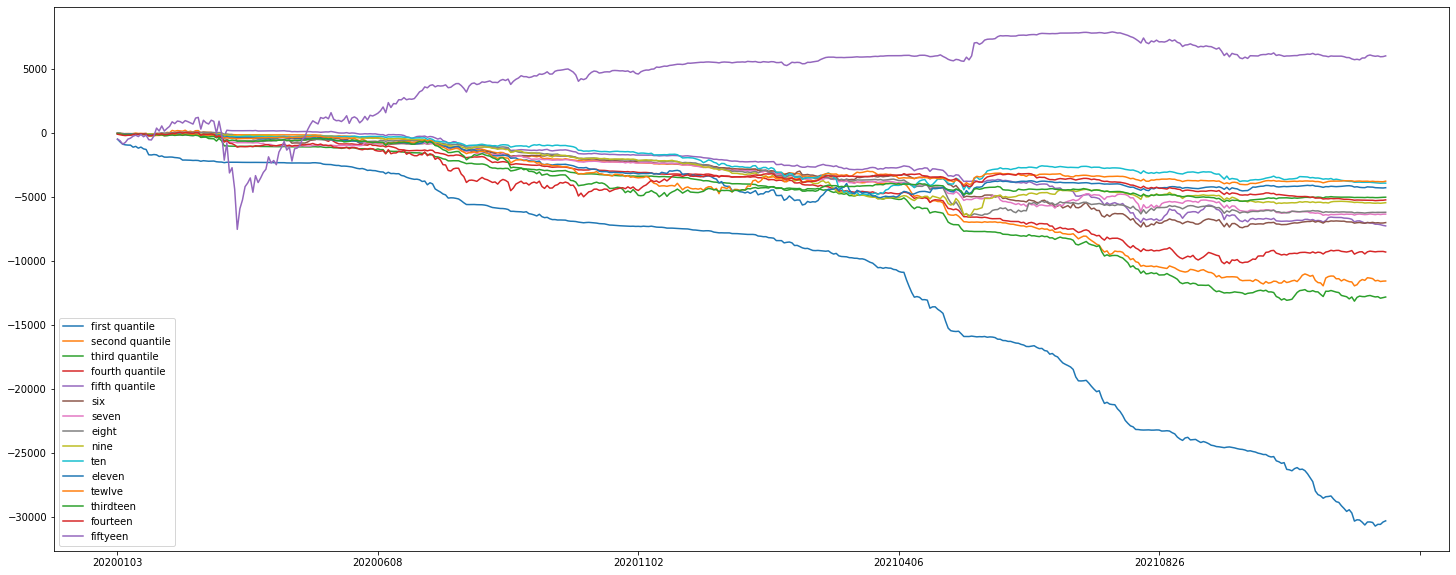

In [66]:
#皆已開盤價買入一單位並在當日以收盤價賣出的005因子各組累積收益
df_group_result = pd.DataFrame()
for i in range(len(df_pct05)-1):
    se =  pd.Series(df_close05.loc[df_pct05.index[i+1],:]- df_open05.loc[df_pct05.index[i+1],:]  ,name=df_pct05.index[i+1])
    df_group_result = df_group_result.append(se.groupby(pd.cut(df_alpha005.loc[df_pct05.index[i],:],15, labels=group_names)).sum())
df_group_result = df_group_result.cumsum()
df_group_result.index = df_group_result.index.astype(str)
df_group_result.plot(figsize=(25,10))

In [9]:
#005因子的first quantile股票字典key = 日期 ,values = 當日應做空的股票(前一日算出)
stock_result_dict_005 = {}
for i in range(len(df_pct05)-1):
    stock_list = list(df_alpha005.loc[df_pct05.index[i],:].keys()[pd.cut(df_alpha005.loc[df_pct05.index[i],:],5, labels=group_names) == 'first quantile'])
    stock_result_dict_005[str(df_pct05.index[i+1])] = stock_list

**<font  size=6> 035因子(正相關，空first quantile) </font>**

In [9]:
df_alpha035 = stock.alpha035().dropna(how='all')
group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
df_pct35= df['pct_chg'][df['pct_chg'].index.isin(df_alpha035.index)]
df_close35= df['close'][df['close'].index.isin(df_alpha035.index)]
df_open35= df['open'][df['open'].index.isin(df_alpha035.index)]

<AxesSubplot:>

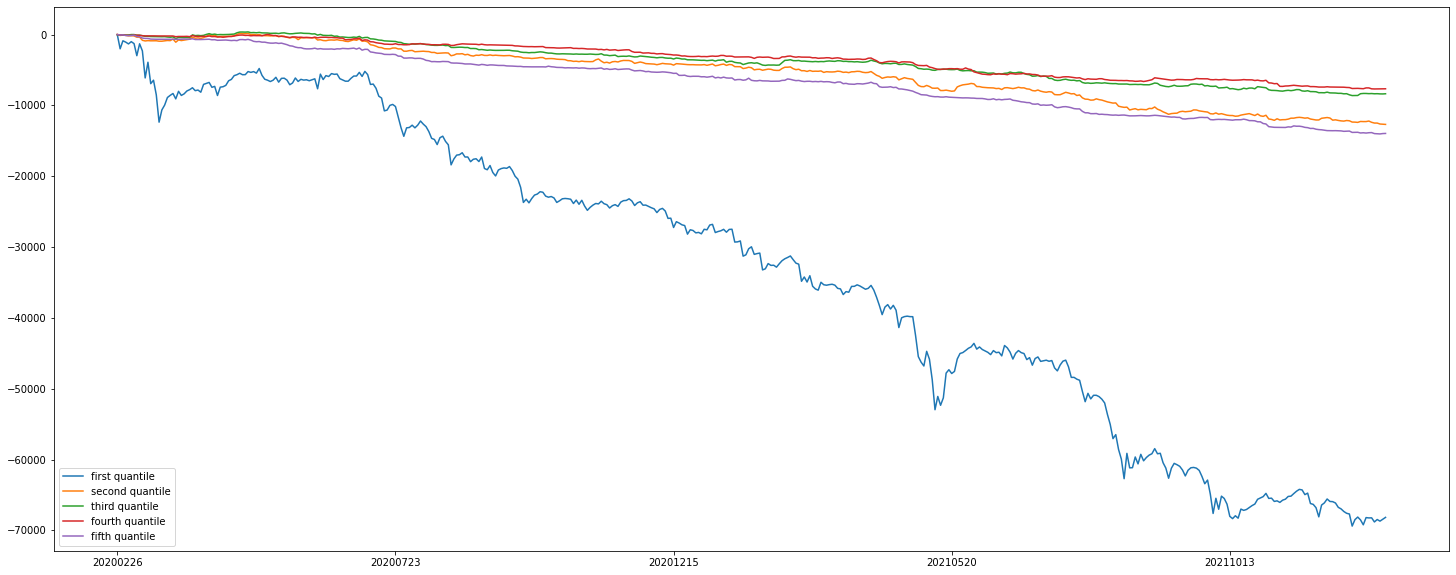

In [32]:
#皆已開盤價買入一單位並在當日以收盤價賣出的035因子各組累積收益
df_group_result = pd.DataFrame()
for i in range(len(df_pct35)-1):
    se =  pd.Series(df_close35.loc[df_pct35.index[i+1],:]- df_open35.loc[df_pct35.index[i+1],:]  ,name=df_pct35.index[i+1])
    df_group_result = df_group_result.append(se.groupby(pd.cut(df_alpha035.loc[df_pct35.index[i],:],5, labels=group_names)).sum())
df_group_result = df_group_result.cumsum()
df_group_result.index = df_group_result.index.astype(str)
df_group_result.plot(figsize=(25,10))

In [ ]:
#035因子的first quantile股票字典key = 日期 ,values = 當日應做空的股票(前一日算出)
stock_result_dict_035 = {}
for i in range(len(df_pct35)-1):
    stock_list = list(df_alpha035.loc[df_pct35.index[i],:].keys()[pd.cut(df_alpha035.loc[df_pct35.index[i],:],5, labels=group_names) == 'first quantile'])
    stock_result_dict_035[str(df_pct35.index[i+1])] = stock_list

**<font  size=6> 011因子(正相關，空first quantile) </font>**

In [21]:
df_alpha011 = stock.alpha011().dropna(how='all')
group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
df_pct11= df['pct_chg'][df['pct_chg'].index.isin(df_alpha011.index)]
df_close11= df['close'][df['close'].index.isin(df_alpha011.index)]
df_open11= df['open'][df['open'].index.isin(df_alpha011.index)]

<AxesSubplot:>

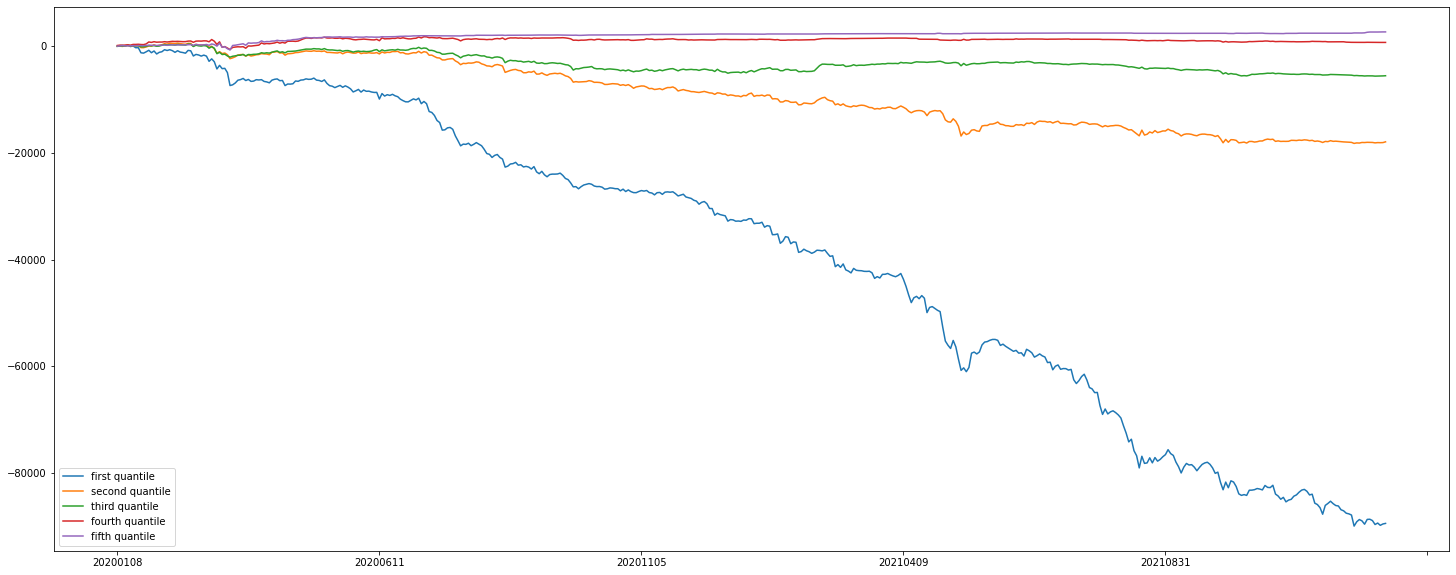

In [33]:
#皆已開盤價買入一單位並在當日以收盤價賣出的011因子各組累積收益
df_group_result = pd.DataFrame()
for i in range(len(df_pct11)-1):
    se =  pd.Series(df_close11.loc[df_pct11.index[i+1],:]- df_open11.loc[df_pct11.index[i+1],:]  ,name=df_pct11.index[i+1])
    df_group_result = df_group_result.append(se.groupby(pd.cut(df_alpha011.loc[df_pct11.index[i],:],5, labels=group_names)).sum())
df_group_result = df_group_result.cumsum()
df_group_result.index = df_group_result.index.astype(str)
df_group_result.plot(figsize=(25,10))

In [ ]:
#011因子的first quantile股票字典key = 日期 ,values = 當日應做空的股票(前一日算出)
stock_result_dict_011 = {}
for i in range(len(df_pct11)-1):
    stock_list = list(df_alpha011.loc[df_pct11.index[i],:].keys()[pd.cut(df_alpha011.loc[df_pct11.index[i],:],5, labels=group_names) == 'first quantile'])
    stock_result_dict_011[str(df_pct11.index[i+1])] = stock_list

**<font  size=6> 038因子(負相關，空fifth quantile) </font>**

In [26]:
df_alpha038 = stock.alpha038().dropna(how='all')
group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
df_pct38= df['pct_chg'][df['pct_chg'].index.isin(df_alpha038.index)]
df_close38= df['close'][df['close'].index.isin(df_alpha038.index)]
df_open38= df['open'][df['open'].index.isin(df_alpha038.index)]

<AxesSubplot:>

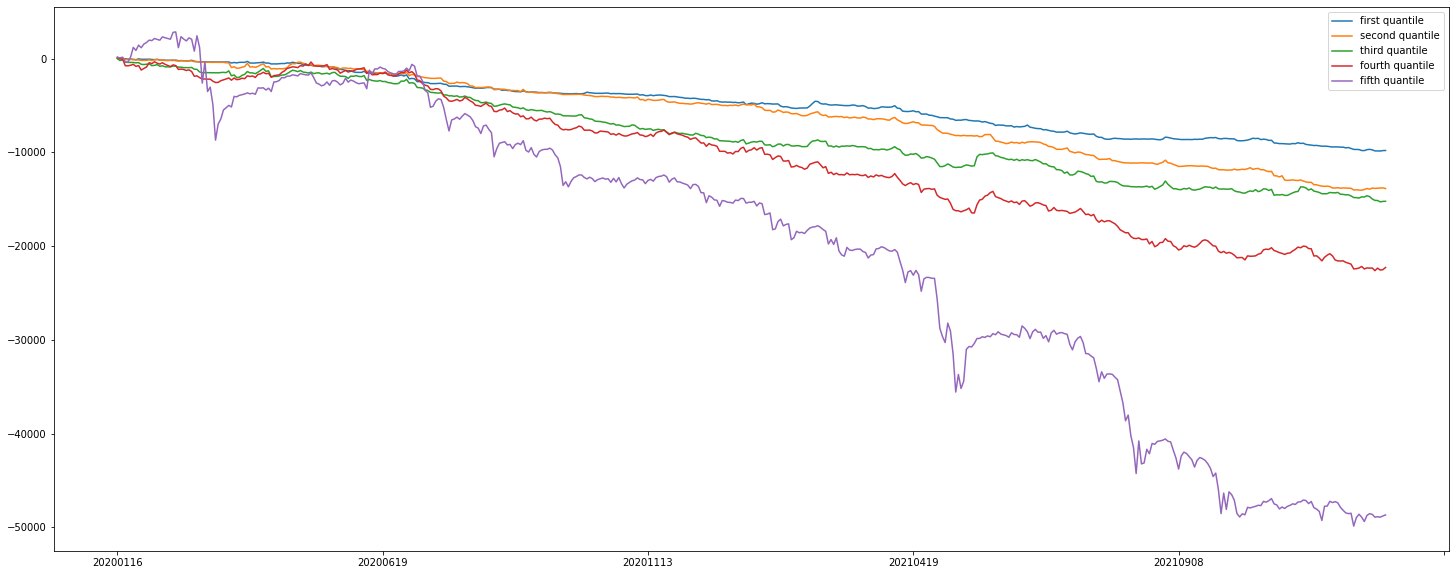

In [34]:
#皆已開盤價買入一單位並在當日以收盤價賣出的011因子各組累積收益
df_group_result = pd.DataFrame()
for i in range(len(df_pct38)-1):
    se =  pd.Series(df_close38.loc[df_pct38.index[i+1],:]- df_open38.loc[df_pct38.index[i+1],:]  ,name=df_pct38.index[i+1])
    df_group_result = df_group_result.append(se.groupby(pd.cut(df_alpha038.loc[df_pct38.index[i],:],5, labels=group_names)).sum())
df_group_result = df_group_result.cumsum()
df_group_result.index = df_group_result.index.astype(str)
df_group_result.plot(figsize=(25,10))

In [ ]:
#011因子的fifth quantile股票字典key = 日期 ,values = 當日應做空的股票(前一日算出)
stock_result_dict_038 = {}
for i in range(len(df_pct38)-1):
    stock_list = list(df_alpha038.loc[df_pct38.index[i],:].keys()[pd.cut(df_alpha038.loc[df_pct38.index[i],:],5, labels=group_names) == 'fifth quantile'])
    stock_result_dict_038[str(df_pct38.index[i+1])] = stock_list

**<font  size=6> 017因子(負相關，空fifth quantile) </font>**

In [28]:
df_alpha017 = stock.alpha017().dropna(how='all')
group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
df_pct17= df['pct_chg'][df['pct_chg'].index.isin(df_alpha017.index)]
df_close17= df['close'][df['close'].index.isin(df_alpha017.index)]
df_open17= df['open'][df['open'].index.isin(df_alpha017.index)]

<AxesSubplot:>

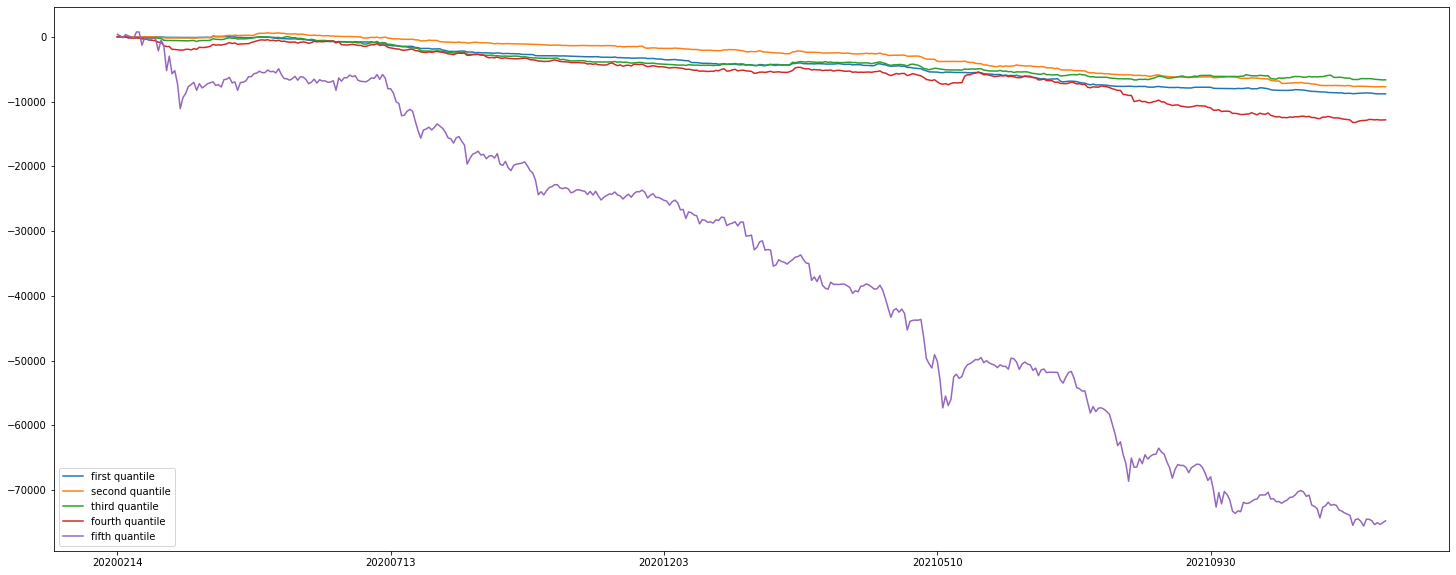

In [35]:
#皆已開盤價買入一單位並在當日以收盤價賣出的011因子各組累積收益
df_group_result = pd.DataFrame()
for i in range(len(df_pct17)-1):
    se =  pd.Series(df_close17.loc[df_pct17.index[i+1],:]- df_open17.loc[df_pct17.index[i+1],:]  ,name=df_pct17.index[i+1])
    df_group_result = df_group_result.append(se.groupby(pd.cut(df_alpha017.loc[df_pct17.index[i],:],5, labels=group_names)).sum())
df_group_result = df_group_result.cumsum()
df_group_result.index = df_group_result.index.astype(str)
df_group_result.plot(figsize=(25,10))

In [ ]:
#011因子的first quantile股票字典key = 日期 ,values = 當日應做空的股票(前一日算出)
stock_result_dict_017 = {}
for i in range(len(df_pct17)-1):
    stock_list = list(df_alpha017.loc[df_pct17.index[i],:].keys()[pd.cut(df_alpha017.loc[df_pct17.index[i],:],5, labels=group_names) == 'fifth quantile'])
    stock_result_dict_017[str(df_pct11.index[i+1])] = stock_list

**<font  size=6> 五天IC</font>**

**<font  size=6> 005因子(正相關，空first quantile) </font>**

In [7]:
stock=Alphas(df)
df_alpha005 = stock.alpha005().dropna(how='all')
# group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
# group_names = ['first quantile', 'second quantile', 'third quantile']
group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile','six','seven','eight','nine','ten','eleven','tewlve','thirdteen','fourteen','fiftyeen']
df_pct05= df['pct_chg'][df['pct_chg'].index.isin(df_alpha005.index)]
df_close05= df['close'][df['close'].index.isin(df_alpha005.index)]
df_open05= df['open'][df['open'].index.isin(df_alpha005.index)]

<AxesSubplot:>

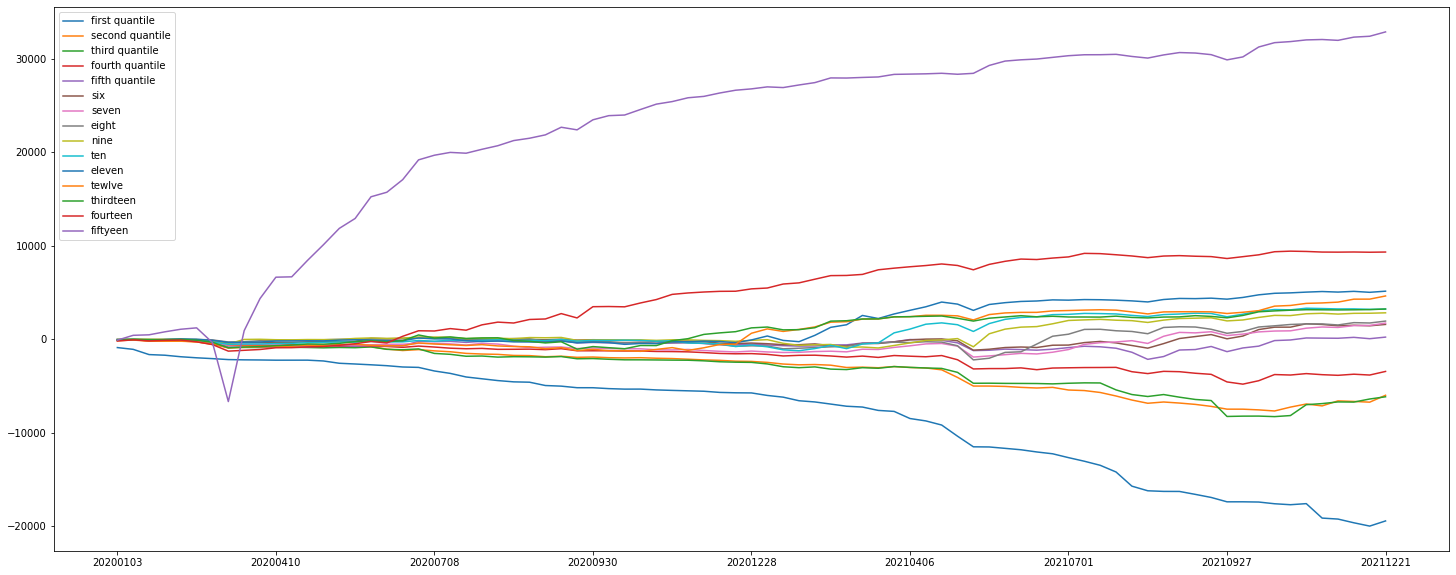

In [8]:
#皆已開盤價買入一單位並在當日以收盤價賣出的005因子各組累積收益
df_group_result = pd.DataFrame()
i=0
while i <= len(df_pct05)-5:
    se =  pd.Series(df_close05.loc[df_pct05.index[i+5],:]- df_open05.loc[df_pct05.index[i+1],:]  ,name=df_pct05.index[i+1])
    df_group_result = df_group_result.append(se.groupby(pd.cut(df_alpha005.loc[df_pct05.index[i],:],15, labels=group_names)).sum())
    i=i+6
df_group_result = df_group_result.cumsum() 
df_group_result.index = df_group_result.index.astype(str)
df_group_result.plot(figsize=(25,10))

In [9]:
#005因子的first quantile股票字典key = 日期 ,values = 當日應做空的股票(前一日算出)
stock_result_dict_005 = {}
for i in range(len(df_pct05)-1):
    stock_list = list(df_alpha005.loc[df_pct05.index[i],:].keys()[pd.cut(df_alpha005.loc[df_pct05.index[i],:],15, labels=group_names) == 'first quantile'])
    stock_result_dict_005[str(df_pct05.index[i+1])] = stock_list

**<font  size=6> 026因子(負相關，空fifth quantile) </font>**

In [ ]:
df_alpha026 = stock.alpha026().dropna(how='all')
group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
df_pct26= df['pct_chg'][df['pct_chg'].index.isin(df_alpha026.index)]
df_close26= df['close'][df['close'].index.isin(df_alpha026.index)]
df_open26= df['open'][df['open'].index.isin(df_alpha026.index)]

In [8]:
#皆已開盤價買入一單位並在當日以收盤價賣出的011因子各組累積收益
df_group_result = pd.DataFrame()
for i in range(len(df_pct26)-5):
    se =  pd.Series(df_close26.loc[df_pct26.index[i+5],:]- df_open26.loc[df_pct26.index[i+1],:]  ,name=df_pct26.index[i+1])
    df_group_result = df_group_result.append(se.groupby(pd.cut(df_alpha026.loc[df_pct26.index[i],:],5, labels=group_names)).sum())
df_group_result = df_group_result.cumsum()
df_group_result.index = df_group_result.index.astype(str)
df_group_result.plot(figsize=(25,10))

NameError: name 'df_pct26' is not defined

**<font  size=6> 回測開始 </font>**

五天調一次倉

In [10]:
stock_tick = df['close']
stock_tick[stock_tick<10] = 0.01
stock_tick[(stock_tick>=10)&(stock_tick<50)] = 0.05
stock_tick[(stock_tick>=50)&(stock_tick<100)] = 0.1
stock_tick[(stock_tick>=100)&(stock_tick<500)] = 0.5
stock_tick[(stock_tick>=500)&(stock_tick<1000)] = 1
stock_tick[stock_tick>=1000] = 5
stock_tick_dict = {}
for i in stock_tick.index:
    stock_tick_dict[str(i)] = stock_tick.loc[i,:]
stock_result_dict_005['20200102'] = []
stock_lists = []
for i in stock_result_dict_005.keys():
    stock_lists.extend(stock_result_dict_005[i])
stocklist = list(set(stock_lists))

In [11]:
#%%
from vnpy_ctastrategy.backtesting import BacktestingEngine, OptimizationSetting
from vnpy_ctastrategy.strategies.simple_short_strategy import (
    SimpleShortStrategy
)
from vnpy_ctastrategy.strategies.short_strategy1 import (
    NSimpleShortStrategy
)
from datetime import datetime

In [12]:
def run_backtesting(strategy_class, setting, vt_symbol, interval, start, end, rate, slippage, size, pricetick, capital):
    engine = BacktestingEngine()
    engine.set_parameters(
        vt_symbol=vt_symbol,
        interval=interval,
        start=start,
        end=end,
        rate=rate,
        slippage=slippage,
        size=size,
        pricetick=pricetick,
        capital=capital    
    )
    engine.add_strategy(strategy_class, setting)
    engine.load_data()
    engine.run_backtesting()
    df = engine.calculate_result()
    engine.calculate_statistics(df)
    order = engine.get_all_orders()
    return df,order

def show_portafolio(df, vt_symbol, interval, start, end, rate, slippage, size, pricetick, capital):
    engine = BacktestingEngine()
    engine.set_parameters(
        vt_symbol=vt_symbol,
        interval=interval,
        start=start,
        end=end,
        rate=rate,
        slippage=slippage,
        size=size,
        pricetick=pricetick,
        capital=capital    
    )
    engine.calculate_statistics(df)
    engine.show_chart(df)

In [ ]:
orderls = []
dfls = []
for stock in tqdm(stocklist):
    df1,order1 = run_backtesting(
        strategy_class= NSimpleShortStrategy, 
        setting={"stock_dict": stock_result_dict_005, "symbol": stock}, 
        vt_symbol= stock +".LOCAL",
        interval="1m", 
        start=datetime(2020, 1, 1), 
        end=datetime(2021, 12, 31),
        rate=0,
        slippage=0,
        size=1000,
        pricetick=stock_tick_dict['20200102'][stock],
        capital=1000000,
        )
    dfls.append(df1)
    orderls.append(order1)

In [40]:
dfls = [i for i in dfls if i is not None]

In [41]:
for i in range(len(dfls)):
    dfls[i] = dfls[i].reindex(dfls[0].index)
    
    if np.isnan(dfls[i].iloc[0,0]) == True:
        dfls[i] = dfls[i].assign(close_price = dfls[i].close_price.fillna(method='bfill'), pre_close = dfls[i].pre_close.bfill(),trades = dfls[i].trades.bfill().ffill(),start_pos = dfls[i].start_pos.fillna(method='bfill'),
                        end_pos = dfls[i].end_pos.fillna(method ='bfill'),  trade_count = dfls[i].trade_count.fillna(0),
                        turnover = dfls[i].turnover.fillna(0), commission = dfls[i].commission.fillna(0),
                        slippage = dfls[i].slippage.fillna(0), trading_pnl = dfls[i].trading_pnl.fillna(0),
                        ).fillna(0)
    else:
        dfls[i] = dfls[i].assign(close_price = dfls[i].close_price.fillna(method='ffill'), pre_close = dfls[i].pre_close.bfill(),trades = dfls[i].trades.bfill().ffill(),trade_count = dfls[i].trade_count.fillna(0),
                        turnover = dfls[i].turnover.fillna(0), commission = dfls[i].commission.fillna(0),
                        slippage = dfls[i].slippage.fillna(0), trading_pnl = dfls[i].trading_pnl.fillna(0),
                        ).fillna(method = 'ffill')


In [42]:
df=dfls[0].copy()
for i in range(1,len(dfls)):
        df+=dfls[i]

In [44]:
df = df.dropna()

In [48]:
show_portafolio(df,
        vt_symbol= "profolio.LOCAL",
        interval="1m", 
        start=datetime(2020, 1, 1), 
        end=datetime(2021, 12, 31),
        rate= 1.5/1000,
        slippage=0,
        size=1000,
        pricetick=0.05,
        capital=50000000)

2022-09-02 16:07:05.920700	开始计算策略统计指标
2022-09-02 16:07:05.928648	------------------------------
2022-09-02 16:07:05.928648	首个交易日：	2020-01-03
2022-09-02 16:07:05.928648	最后交易日：	2021-12-30
2022-09-02 16:07:05.928648	总交易日：	485
2022-09-02 16:07:05.928648	盈利交易日：	339
2022-09-02 16:07:05.928648	亏损交易日：	146
2022-09-02 16:07:05.928648	起始资金：	50,000,000.00
2022-09-02 16:07:05.928648	结束资金：	80,417,370.00
2022-09-02 16:07:05.928648	总收益率：	60.83%
2022-09-02 16:07:05.928648	年化收益：	30.10%
2022-09-02 16:07:05.928648	最大回撤: 	-1,383,990.00
2022-09-02 16:07:05.928648	百分比最大回撤: -1.69%
2022-09-02 16:07:05.928648	最长回撤天数: 	16
2022-09-02 16:07:05.928648	总盈亏：	30,417,370.00
2022-09-02 16:07:05.928648	总手续费：	0.00
2022-09-02 16:07:05.928648	总滑点：	0.00
2022-09-02 16:07:05.928648	总成交金额：	1,630,695,850.00
2022-09-02 16:07:05.928648	总成交笔数：	18304.0
2022-09-02 16:07:05.928648	日均盈亏：	62,716.23
2022-09-02 16:07:05.928648	日均手续费：	0.00
2022-09-02 16:07:05.928648	日均滑点：	0.00
2022-09-02 16:07:05.928648	日均成交金额：	3,362,259.48
2022-09-02 16:0